# Object (ship) Detection using Fast Vision Decoder (FViD)

This notebook contains a process of creating an end to end fast vision decoder model using tensorflow. The model uses pretrained weights and convolution auto-encoder. This implementation used tiny dataset with above average accuracy.

It is divided up into 2 sections:

1. Part 1: Selecting of an appropriate pretrained model used as the FViD base model.
2. Part 2: Loading a custom autoencoder on the pretrained weights for ship detection purposes

In [1]:
!pip install pydot_ng
!pip install graphviz

# Importing libraries


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, random, cv2, pickle, json, itertools
import imgaug.augmenters as iaa
import imgaug.imgaug
import tensorflow as tf

from IPython.display import SVG
from tf.keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from scipy import interp
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support,roc_curve,auc
from collections import Counter
from sklearn.utils import class_weight
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer

from tf.keras.utils import to_categorical
from tf.keras.models import Sequential, Model
from tf.keras.layers import (Add,Attention,Multiply,LeakyReLU, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, ReLu, Conv2DTranspose, Flatten, Dense)
from tf.keras.optimizers import Adam, SGD
from tf.keras.callbacks import TensorBoard, ModelCheckpoint, Callback, EarlyStopping
from tf.keras.preprocessing.image import ImageDataGenerator
import pydot_ng as pydot
import pydotplus
import graphviz
from tqdm import tqdm
import inspect


In [3]:
# Set batch size for training and validation
batch_size = 32

In [4]:
# List all available models
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}

In [5]:
print(model_dictionary)

{'DenseNet121': <function DenseNet121 at 0x7fb1bb0e1440>, 'DenseNet169': <function DenseNet169 at 0x7fb1bb0e14d0>, 'DenseNet201': <function DenseNet201 at 0x7fb1bb0e1560>, 'EfficientNetB0': <function EfficientNetB0 at 0x7fb1bb0e6320>, 'EfficientNetB1': <function EfficientNetB1 at 0x7fb1bb0e63b0>, 'EfficientNetB2': <function EfficientNetB2 at 0x7fb1bb0e6440>, 'EfficientNetB3': <function EfficientNetB3 at 0x7fb1bb0e64d0>, 'EfficientNetB4': <function EfficientNetB4 at 0x7fb1bb0e6560>, 'EfficientNetB5': <function EfficientNetB5 at 0x7fb1bb0e65f0>, 'EfficientNetB6': <function EfficientNetB6 at 0x7fb1bb0e6680>, 'EfficientNetB7': <function EfficientNetB7 at 0x7fb1bb0e6710>, 'EfficientNetV2B0': <function EfficientNetV2B0 at 0x7fb1bb0ee9e0>, 'EfficientNetV2B1': <function EfficientNetV2B1 at 0x7fb1bb0eea70>, 'EfficientNetV2B2': <function EfficientNetV2B2 at 0x7fb1bb0eeb00>, 'EfficientNetV2B3': <function EfficientNetV2B3 at 0x7fb1bb0eeb90>, 'EfficientNetV2L': <function EfficientNetV2L at 0x7fb1bb

# Utility functions

* show_final_history - For plotting the loss and accuracy of the training and validation datasets
* plot_confusion_matrix - For plotting the percentage of true positives per class for a better feel of how the model predicted the data

In [6]:
def show_final_history(history):
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')
    ax[1].plot(history.history['accuracy'],label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'],label='Validation Accuracy')
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    plt.gcf().set_dpi(400)
    plt.savefig("final_loss_accuracy_plot.tiff", format='tiff', bbox_inches='tight')
    plt.show();
    pass

In [7]:
def plot_confusion_matrix_final(cm,classes,title='Fast vision decoder confusion matrix',cmap=plt.cm.Blues):
    
#     np.seterr(divide='ignore',invalid='ignore')
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.gcf().set_dpi(300)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

# Uploading the images

250 images of ships collected from six TerraSAR-X stripmap-mode synthetic aperture radar, with 2.0 m X 1.5 m resolution in the azimuth direction, acquired in Hongkong area between 2008-2010 is loaded into numpy arrays, with labels [0,1,2] corresponding to the classes *BulkCarrier*, *ContainerShip* and *OilTanker*. 

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
datasets = ['/content/gdrive/MyDrive/ship_detect']

class_names = ["BulkCarrier","ContainerShip", "OilTanker" ]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

num_classes = len(class_names)
class_name_labels

{'BulkCarrier': 0, 'ContainerShip': 1, 'OilTanker': 2}

In [10]:
def load_data():
    images, labels = [], []
    
    for dataset in datasets:
        
        for folder in os.listdir(dataset):
            label = class_name_labels[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                
                img_path = os.path.join(dataset,folder,file)
                
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (224,224))
                
                images.append(img)
                labels.append(label)
                pass
            pass
        
        images = np.array(images,dtype=np.float32)/255.0
        labels = np.array(labels,dtype=np.float32)
        pass
    
    return (images, labels)
    pass

In [11]:
(images, labels) = load_data()
images.shape, labels.shape

100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


((250, 224, 224, 3), (250,))

# EDA of dataset

* bar-plot - Bar plot is made to find the count of images per class
* pie-plot - Pie plot is drawn to find the percentage of class distribution in the dataset

In [12]:
n_labels = labels.shape[0]

_, count = np.unique(labels, return_counts=True)

df = pd.DataFrame(data = count)
df['Class Label'] = class_names
df.columns = ['Count','Class-Label']
df.set_index('Class-Label',inplace=True)
df

,Count
Class-Label,
BulkCarrier,150
ContainerShip,50
OilTanker,50


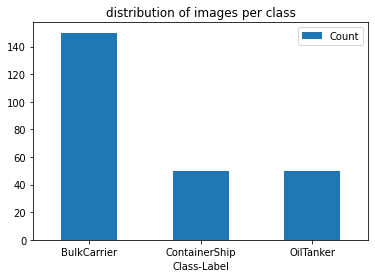

In [13]:
df.plot.bar(rot=0)
plt.title("distribution of images per class");

As it can be seen that the data is skewed towards the *no-ship* class with 75% of images belonging to that very specific class.

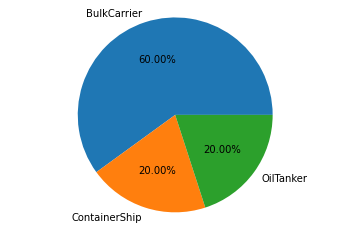

In [14]:
plt.pie(count,
       explode=(0,0,0),
       labels=class_names,
       autopct="%1.2f%%")
plt.axis('equal');

Due to imbalance in dataset, upsampling is done on the two minority classes, using the image augmentation functions below. Post-augmentation, the datasets have comparable distribution as shown in the chat below. Then the dataset is split into the training, testing and validation sets.

**Another way is to introduce class weights for each specific class. Each class is penalised with the specific class weight. Higher the class weight, greater the penalty. Classes with lower percentage have a higher penalty. This allows for the model to penalise itself heavily if class detected is incorrect**.

In [15]:
AUGMENTATION = True

In [16]:
def augment_add(images, seq, labels):
    
    augmented_images, augmented_labels = [],[]
    for idx,img in tqdm(enumerate(images)):
        
        if labels[idx] == 1:
            image_aug_1 = seq.augment_image(image=img)
            image_aug_2 = seq.augment_image(image=img)
            augmented_images.append(image_aug_1)
            augmented_images.append(image_aug_2)
            augmented_labels.append(labels[idx])
            augmented_labels.append(labels[idx])
        elif labels[idx] ==2:
            image_aug_1 = seq.augment_image(image=img)
            image_aug_2 = seq.augment_image(image=img)
            augmented_images.append(image_aug_1)
            augmented_images.append(image_aug_2)
            augmented_labels.append(labels[idx])
            augmented_labels.append(labels[idx])

        pass
    augmented_images = np.array(augmented_images, dtype=np.float32)
    augmented_labels = np.array(augmented_labels, dtype=np.float32)
    return (augmented_images, augmented_labels)
    pass

In [17]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0,0.1)),
    iaa.LinearContrast((0.75,1.5)),
    iaa.Multiply((0.8,1.2), per_channel=0.2),
    iaa.Affine(
        scale={'x':(0.8,1.2), "y":(0.8,1.2)},
        translate_percent={"x":(-0.2,0.2),"y":(-0.2,0.2)},
        rotate=(-25,25),
        shear=(-8,8)
    )
], random_order=True)

In [18]:
if AUGMENTATION:
    (aug_images, aug_labels) = augment_add(images, seq, labels)
    images = np.concatenate([images, aug_images])
    labels = np.concatenate([labels, aug_labels])

250it [00:02, 123.28it/s] 


In [19]:
images.shape, labels.shape

((450, 224, 224, 3), (450,))

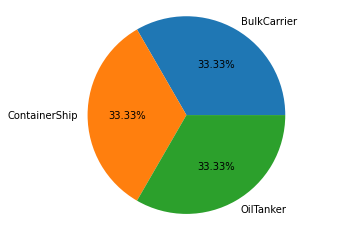

In [20]:
if AUGMENTATION:
    _, count = np.unique(labels, return_counts=True)

    plt.pie(count,
           explode=(0,0,0),
           labels=class_names,
           autopct="%1.2f%%")
    plt.axis('equal');

# One Hot Encoding Variables

The labels numpy array is one hot encoded using *to_categorical* from keras. This removes any uncessary bias in the dataset, by keeping the class at equal footing, with respect to labels. 

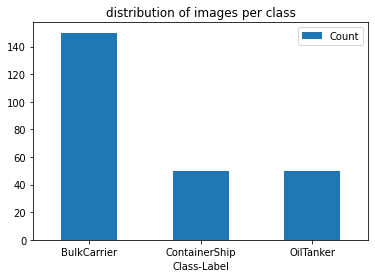

In [21]:
df.plot.bar(rot=0)
plt.title("distribution of images per class");

In [22]:
labels = to_categorical(labels)

# Training, Validation and Testing



In [23]:
np.random.seed(42)
np.random.shuffle(images)

np.random.seed(42)
np.random.shuffle(labels)

## Spliting of data

* 70% - Training
* 20% - Validation
* 10% - Testing

In [24]:
total_count = len(images)
total_count

train = int(0.7*total_count)
val = int(0.2*total_count)
test = int(0.1*total_count)

train_images, train_labels = images[:train], labels[:train]
val_images, val_labels = images[train:(val+train)], labels[train:(val+train)]
test_images, test_labels = images[-test:], labels[-test:]

train_images.shape, val_images.shape, test_images.shape

((315, 224, 224, 3), (90, 224, 224, 3), (45, 224, 224, 3))

If AUGMENTATION is set True, then the number of images per class is balanced. If AUGMENTATION is set to False, then compute the class weights given below and accordingly change the fit function of the Keras API when training.

In [25]:
if not AUGMENTATION:
    count_labels = train_labels.sum(axis=0)

    classTotals = train_labels.sum(axis=0)
    classWeight = {}

    for i in range(0,len(classTotals)):
        classWeight[i] = classTotals.max()/classTotals[i]
        pass
    print(classWeight)

# Pretrain model selection: 

* **Pretrained Model Selection** - Since there are over 25 pretrained models in the Keras library, the question is which of these models will have the best weight for the task at hand? To answer this question, we loop over all the models using a subset of the datset. The best model was subsequently used as the base model for FViD.

In [26]:
def normalize_img_train(image_train, img_size):
    # Resize image to the desired img_size and normalize it
    # One hot encode the label
    train_processed_331 = tf.image.resize(image_train, img_size)
    #train_processed_331 = train_processed_331.batch(batch_size).repeat()
    #train_processed_331  = tf.cast(train_processed_331, tf.float32) / 255.
    return  train_processed_331


def normalize_img_val(image_val, img_size):
    validation_processed_331= tf.image.resize(image_val, img_size)
    #validation_processed_331 = tf.cast(validation_processed_331, tf.float32) / 255.
    #label = tf.one_hot(label, depth=num_classes)
    return validation_processed_331

In [27]:
train_processed_331 =normalize_img_train(train_images, img_size=[331,331])
validation_processed_331 = normalize_img_val(val_images, img_size=[331,331])

In [28]:
train_processed_384 =normalize_img_train(train_images, img_size=[384,384])
validation_processed_384 = normalize_img_val(val_images, img_size=[384,384])

In [29]:
# Loop over each model available in Keras
METRICS = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': []}
for model_name, model in tqdm(model_dictionary.items()):
    # Special handling for "NASNetLarge" since it requires input images with size (331,331)
    if 'NASNetLarge' in model_name:
        input_shape=(331,331,3)
        train_d = train_processed_331
        val_d = validation_processed_331
    
    else:
        input_shape=(224,224,3)
        train_d = train_images
        val_d = val_images

    # load the pre-trained model with global average pooling as the last layer and freeze the model weights
    pre_trained_model = model(include_top=False, pooling='avg', input_shape=input_shape)
    pre_trained_model.trainable = False
       # custom modifications on top of pre-trained model
    clf_model = tf.keras.models.Sequential()
    clf_model.add(pre_trained_model)
    clf_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    clf_model.compile(loss='categorical_crossentropy', metrics=METRICS)
    history = clf_model.fit(train_d,train_labels, epochs=3, validation_data=(val_d, val_labels),
                           steps_per_epoch=len(train_images)//batch_size)
    # Calculate all relevant metrics
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
    model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])

  0%|          | 0/35 [00:00<?, ?it/s]

29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/3
9/9 [==============================] - 66s 7s/step - loss: 0.9942 - accuracy: 0.4984 - precision: 0.5928 - recall: 0.3143 - val_loss: 0.7503 - val_accuracy: 0.7444 - val_precision: 0.7895 - val_recall: 0.5000
Epoch 2/3
9/9 [==============================] - 60s 7s/step - loss: 0.6826 - accuracy: 0.7333 - precision: 0.7842 - recall: 0.6000 - val_loss: 0.5914 - val_accuracy: 0.7889 - val_precision: 0.8354 - val_recall: 0.7333
Epoch 3/3
9/9 [==============================] - 61s 6s/step - loss: 0.5397 - accuracy: 0.8063 - precision: 0.8507 - recall: 0.7238 - val_loss: 0.5346 - val_accuracy: 0.7333 - val_precision: 0.7647 - val_recall: 0.7222


  3%|▎         | 1/35 [03:34<2:01:24, 214.26s/it]

51888128/51877672 [==============================] - 0s 0us/step
Epoch 1/3
9/9 [==============================] - 80s 8s/step - loss: 0.8012 - accuracy: 0.6698 - precision: 0.7518 - recall: 0.5235 - val_loss: 0.5666 - val_accuracy: 0.7778 - val_precision: 0.8481 - val_recall: 0.7444
Epoch 2/3
9/9 [==============================] - 66s 8s/step - loss: 0.4914 - accuracy: 0.8413 - precision: 0.8664 - recall: 0.7619 - val_loss: 0.4866 - val_accuracy: 0.7667 - val_precision: 0.7654 - val_recall: 0.6889
Epoch 3/3
9/9 [==============================] - 66s 8s/step - loss: 0.4051 - accuracy: 0.8667 - precision: 0.8818 - recall: 0.8286 - val_loss: 0.3634 - val_accuracy: 0.9222 - val_precision: 0.9326 - val_recall: 0.9222


  6%|▌         | 2/35 [07:12<1:59:17, 216.88s/it]

74850304/74836368 [==============================] - 0s 0us/step
Epoch 1/3
9/9 [==============================] - 100s 10s/step - loss: 0.7558 - accuracy: 0.6984 - precision: 0.8478 - recall: 0.6049 - val_loss: 0.6113 - val_accuracy: 0.6889 - val_precision: 0.7595 - val_recall: 0.6667
Epoch 2/3
9/9 [==============================] - 84s 10s/step - loss: 0.4886 - accuracy: 0.8540 - precision: 0.9018 - recall: 0.7873 - val_loss: 0.4231 - val_accuracy: 0.8778 - val_precision: 0.8721 - val_recall: 0.8333
Epoch 3/3
9/9 [==============================] - 84s 10s/step - loss: 0.3854 - accuracy: 0.9048 - precision: 0.9161 - recall: 0.8667 - val_loss: 0.3466 - val_accuracy: 0.9000 - val_precision: 0.8989 - val_recall: 0.8889


  9%|▊         | 3/35 [11:55<2:11:34, 246.72s/it]

16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/3
9/9 [==============================] - 29s 2s/step - loss: 1.1101 - accuracy: 0.3492 - precision: 0.8989 - recall: 0.1975 - val_loss: 1.1001 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
9/9 [==============================] - 20s 2s/step - loss: 1.1062 - accuracy: 0.3365 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1003 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
9/9 [==============================] - 20s 2s/step - loss: 1.1042 - accuracy: 0.2921 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1067 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


 11%|█▏        | 4/35 [13:27<1:36:02, 185.89s/it]

27033600/27018416 [==============================] - 1s 0us/step
Epoch 1/3
9/9 [==============================] - 40s 3s/step - loss: 1.1240 - accuracy: 0.2984 - precision: 0.2143 - recall: 0.0074 - val_loss: 1.0983 - val_accuracy: 0.3667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
9/9 [==============================] - 27s 3s/step - loss: 1.1067 - accuracy: 0.3111 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0954 - val_accuracy: 0.3667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
9/9 [==============================] - 27s 3s/step - loss: 1.1140 - accuracy: 0.2952 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0979 - val_accuracy: 0.3667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


 14%|█▍        | 5/35 [16:05<1:27:49, 175.64s/it]

31801344/31790344 [==============================] - 1s 0us/step
Epoch 1/3
9/9 [==============================] - 42s 4s/step - loss: 1.1421 - accuracy: 0.3175 - precision: 0.2941 - recall: 0.0247 - val_loss: 1.1102 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
9/9 [==============================] - 30s 3s/step - loss: 1.1115 - accuracy: 0.3460 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1075 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
9/9 [==============================] - 29s 3s/step - loss: 1.1050 - accuracy: 0.3714 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0988 - val_accuracy: 0.3667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


 17%|█▋        | 6/35 [18:41<1:21:45, 169.14s/it]

43950080/43941136 [==============================] - 0s 0us/step
Epoch 1/3
9/9 [==============================] - 53s 5s/step - loss: 1.1438 - accuracy: 0.3365 - precision: 0.2444 - recall: 0.0272 - val_loss: 1.1136 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
9/9 [==============================] - 40s 5s/step - loss: 1.1290 - accuracy: 0.3048 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0970 - val_accuracy: 0.3333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
9/9 [==============================] - 40s 5s/step - loss: 1.1129 - accuracy: 0.3302 - precision: 0.6667 - recall: 0.0063 - val_loss: 1.1052 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


 20%|██        | 7/35 [21:00<1:14:21, 159.34s/it]

71696384/71686520 [==============================] - 1s 0us/step
Epoch 1/3
9/9 [==============================] - 71s 7s/step - loss: 1.1630 - accuracy: 0.3365 - precision: 0.2688 - recall: 0.0617 - val_loss: 1.1283 - val_accuracy: 0.3333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
9/9 [==============================] - 54s 6s/step - loss: 1.1313 - accuracy: 0.2857 - precision: 1.0000 - recall: 0.0063 - val_loss: 1.1390 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
9/9 [==============================] - 54s 6s/step - loss: 1.1298 - accuracy: 0.3079 - precision: 0.3750 - recall: 0.0095 - val_loss: 1.1246 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


 23%|██▎       | 8/35 [24:42<1:20:36, 179.12s/it]

115277824/115263384 [==============================] - 4s 0us/step
Epoch 1/3
9/9 [==============================] - 98s 10s/step - loss: 1.1961 - accuracy: 0.2889 - precision: 0.3137 - recall: 0.0395 - val_loss: 1.0966 - val_accuracy: 0.3667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
9/9 [==============================] - 80s 9s/step - loss: 1.1344 - accuracy: 0.3111 - precision: 0.1429 - recall: 0.0127 - val_loss: 1.1106 - val_accuracy: 0.3333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
9/9 [==============================] - 79s 9s/step - loss: 1.1115 - accuracy: 0.3460 - precision: 1.0000 - recall: 0.0032 - val_loss: 1.1227 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


 26%|██▌       | 9/35 [29:31<1:32:31, 213.50s/it]

165249024/165234480 [==============================] - 6s 0us/step
Epoch 1/3
9/9 [==============================] - 128s 13s/step - loss: 1.1690 - accuracy: 0.3016 - precision: 0.3226 - recall: 0.0494 - val_loss: 1.1694 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
9/9 [==============================] - 105s 12s/step - loss: 1.0987 - accuracy: 0.4000 - precision: 0.4483 - recall: 0.0413 - val_loss: 1.1148 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
9/9 [==============================] - 104s 12s/step - loss: 1.1574 - accuracy: 0.3270 - precision: 0.3333 - recall: 0.0159 - val_loss: 1.1069 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


 29%|██▊       | 10/35 [35:27<1:47:14, 257.36s/it]

258088960/258076736 [==============================] - 2s 0us/step
Epoch 1/3
9/9 [==============================] - 174s 17s/step - loss: 1.1816 - accuracy: 0.3556 - precision: 0.3750 - recall: 0.1407 - val_loss: 1.1077 - val_accuracy: 0.3667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
9/9 [==============================] - 147s 17s/step - loss: 1.1357 - accuracy: 0.3524 - precision: 0.2439 - recall: 0.0317 - val_loss: 1.1821 - val_accuracy: 0.3000 - val_precision: 0.3000 - val_recall: 0.3000
Epoch 3/3
9/9 [==============================] - 147s 17s/step - loss: 1.1423 - accuracy: 0.3429 - precision: 0.3333 - recall: 0.0857 - val_loss: 1.1181 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


 31%|███▏      | 11/35 [44:22<2:17:02, 342.59s/it]

24289280/24274472 [==============================] - 1s 0us/step
Epoch 1/3
9/9 [==============================] - 28s 2s/step - loss: 1.1274 - accuracy: 0.3365 - precision: 0.3714 - recall: 0.0321 - val_loss: 1.1275 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
9/9 [==============================] - 18s 2s/step - loss: 1.1188 - accuracy: 0.3524 - precision: 0.3714 - recall: 0.0413 - val_loss: 1.1029 - val_accuracy: 0.3667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
9/9 [==============================] - 18s 2s/step - loss: 1.1210 - accuracy: 0.3206 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1174 - val_accuracy: 0.3333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


 34%|███▍      | 12/35 [45:32<1:39:30, 259.60s/it]

28467200/28456008 [==============================] - 1s 0us/step
Epoch 1/3
9/9 [==============================] - 36s 3s/step - loss: 1.1446 - accuracy: 0.3048 - precision: 0.2308 - recall: 0.0222 - val_loss: 1.1304 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
9/9 [==============================] - 25s 3s/step - loss: 1.1083 - accuracy: 0.3429 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1060 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
9/9 [==============================] - 24s 3s/step - loss: 1.1090 - accuracy: 0.3302 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0975 - val_accuracy: 0.3333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


 37%|███▋      | 13/35 [47:04<1:16:29, 208.61s/it]

35848192/35839040 [==============================] - 1s 0us/step
Epoch 1/3
9/9 [==============================] - 42s 4s/step - loss: 1.1374 - accuracy: 0.2921 - precision: 0.3429 - recall: 0.0296 - val_loss: 1.1238 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
9/9 [==============================] - 29s 3s/step - loss: 1.1158 - accuracy: 0.3333 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0968 - val_accuracy: 0.3333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
9/9 [==============================] - 29s 3s/step - loss: 1.1114 - accuracy: 0.3524 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1189 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


 40%|████      | 14/35 [49:41<1:07:39, 193.29s/it]

52617216/52606240 [==============================] - 1s 0us/step
Epoch 1/3
9/9 [==============================] - 50s 5s/step - loss: 1.1277 - accuracy: 0.3397 - precision: 0.3714 - recall: 0.0321 - val_loss: 1.1282 - val_accuracy: 0.3333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
9/9 [==============================] - 38s 4s/step - loss: 1.1180 - accuracy: 0.3302 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1028 - val_accuracy: 0.3667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
9/9 [==============================] - 38s 4s/step - loss: 1.1161 - accuracy: 0.3016 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1034 - val_accuracy: 0.3333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


 43%|████▎     | 15/35 [52:19<1:00:51, 182.58s/it]

473186304/473176280 [==============================] - 11s 0us/step
Epoch 1/3
9/9 [==============================] - 234s 24s/step - loss: 1.1049 - accuracy: 0.3238 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0923 - val_accuracy: 0.3111 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
9/9 [==============================] - 202s 23s/step - loss: 1.0926 - accuracy: 0.3524 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0870 - val_accuracy: 0.3889 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
9/9 [==============================] - 202s 23s/step - loss: 1.0864 - accuracy: 0.4286 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0834 - val_accuracy: 0.3778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


 46%|████▌     | 16/35 [1:03:25<1:43:55, 328.17s/it]

214212608/214201816 [==============================] - 5s 0us/step
Epoch 1/3
9/9 [==============================] - 121s 12s/step - loss: 1.1101 - accuracy: 0.3302 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0997 - val_accuracy: 0.3333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
9/9 [==============================] - 97s 11s/step - loss: 1.0998 - accuracy: 0.3302 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0975 - val_accuracy: 0.3333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
9/9 [==============================] - 97s 11s/step - loss: 1.0972 - accuracy: 0.3524 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0931 - val_accuracy: 0.3667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


 49%|████▊     | 17/35 [1:09:22<1:40:58, 336.56s/it]

82436096/82420632 [==============================] - 2s 0us/step
Epoch 1/3
9/9 [==============================] - 69s 7s/step - loss: 1.0392 - accuracy: 0.5238 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.9901 - val_accuracy: 0.6444 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
9/9 [==============================] - 54s 6s/step - loss: 0.9584 - accuracy: 0.5778 - precision: 0.5909 - recall: 0.0413 - val_loss: 0.9535 - val_accuracy: 0.5778 - val_precision: 0.5000 - val_recall: 0.0444
Epoch 3/3
9/9 [==============================] - 54s 6s/step - loss: 0.9161 - accuracy: 0.6032 - precision: 0.7308 - recall: 0.1206 - val_loss: 0.9319 - val_accuracy: 0.5222 - val_precision: 0.5238 - val_recall: 0.1222


 51%|█████▏    | 18/35 [1:13:05<1:25:42, 302.47s/it]

219070464/219055592 [==============================] - 1s 0us/step
Epoch 1/3
9/9 [==============================] - 109s 11s/step - loss: 0.9146 - accuracy: 0.6159 - precision: 0.6217 - recall: 0.4099 - val_loss: 0.6281 - val_accuracy: 0.6889 - val_precision: 0.7284 - val_recall: 0.6556
Epoch 2/3
9/9 [==============================] - 93s 11s/step - loss: 0.5724 - accuracy: 0.7365 - precision: 0.7891 - recall: 0.6889 - val_loss: 0.4558 - val_accuracy: 0.8222 - val_precision: 0.8313 - val_recall: 0.7667
Epoch 3/3
9/9 [==============================] - 93s 11s/step - loss: 0.4303 - accuracy: 0.8286 - precision: 0.8488 - recall: 0.7841 - val_loss: 0.3947 - val_accuracy: 0.8556 - val_precision: 0.8588 - val_recall: 0.8111


 54%|█████▍    | 19/35 [1:18:51<1:24:08, 315.53s/it]

87924736/87910968 [==============================] - 2s 0us/step
Epoch 1/3
9/9 [==============================] - 48s 5s/step - loss: 1.0320 - accuracy: 0.5524 - precision: 0.6647 - recall: 0.5481 - val_loss: 0.5675 - val_accuracy: 0.7889 - val_precision: 0.7927 - val_recall: 0.7222
Epoch 2/3
9/9 [==============================] - 40s 5s/step - loss: 0.5206 - accuracy: 0.7841 - precision: 0.8114 - recall: 0.7238 - val_loss: 0.3901 - val_accuracy: 0.9000 - val_precision: 0.8966 - val_recall: 0.8667
Epoch 3/3
9/9 [==============================] - 40s 5s/step - loss: 0.3914 - accuracy: 0.8508 - precision: 0.8840 - recall: 0.8222 - val_loss: 0.3451 - val_accuracy: 0.8667 - val_precision: 0.8941 - val_recall: 0.8444


 57%|█████▋    | 20/35 [1:21:23<1:06:39, 266.65s/it]

17235968/17225924 [==============================] - 1s 0us/step
Epoch 1/3
9/9 [==============================] - 16s 2s/step - loss: 0.7218 - accuracy: 0.6667 - precision: 0.7577 - recall: 0.6642 - val_loss: 0.5512 - val_accuracy: 0.7444 - val_precision: 0.7711 - val_recall: 0.7111
Epoch 2/3
9/9 [==============================] - 14s 2s/step - loss: 0.4213 - accuracy: 0.8286 - precision: 0.8475 - recall: 0.7937 - val_loss: 0.4510 - val_accuracy: 0.7889 - val_precision: 0.8023 - val_recall: 0.7667
Epoch 3/3
9/9 [==============================] - 13s 2s/step - loss: 0.3503 - accuracy: 0.8603 - precision: 0.8725 - recall: 0.8476 - val_loss: 0.3906 - val_accuracy: 0.8333 - val_precision: 0.8315 - val_recall: 0.8222


 60%|██████    | 21/35 [1:22:50<49:38, 212.76s/it]  

9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/3
9/9 [==============================] - 17s 1s/step - loss: 0.8934 - accuracy: 0.5651 - precision: 0.6469 - recall: 0.5654 - val_loss: 0.5542 - val_accuracy: 0.7444 - val_precision: 0.7470 - val_recall: 0.6889
Epoch 2/3
9/9 [==============================] - 11s 1s/step - loss: 0.5039 - accuracy: 0.7270 - precision: 0.7483 - recall: 0.7079 - val_loss: 0.5050 - val_accuracy: 0.7333 - val_precision: 0.7471 - val_recall: 0.7222
Epoch 3/3
9/9 [==============================] - 11s 1s/step - loss: 0.4249 - accuracy: 0.7651 - precision: 0.7735 - recall: 0.7587 - val_loss: 0.3945 - val_accuracy: 0.8333 - val_precision: 0.8409 - val_recall: 0.8222


 63%|██████▎   | 22/35 [1:23:38<35:23, 163.31s/it]

12697600/12683000 [==============================] - 0s 0us/step
Epoch 1/3
9/9 [==============================] - 16s 1s/step - loss: 1.0997 - accuracy: 0.3397 - precision: 0.8409 - recall: 0.1827 - val_loss: 1.1137 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
9/9 [==============================] - 10s 1s/step - loss: 1.0961 - accuracy: 0.3587 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0971 - val_accuracy: 0.3222 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
9/9 [==============================] - 10s 1s/step - loss: 1.0942 - accuracy: 0.3587 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0884 - val_accuracy: 0.3667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


 66%|██████▌   | 23/35 [1:24:26<25:42, 128.53s/it]

4349952/4334752 [==============================] - 0s 0us/step
Epoch 1/3
9/9 [==============================] - 9s 597ms/step - loss: 1.1080 - accuracy: 0.3556 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1142 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
9/9 [==============================] - 4s 448ms/step - loss: 1.1025 - accuracy: 0.3333 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1026 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
9/9 [==============================] - 4s 449ms/step - loss: 1.1015 - accuracy: 0.3238 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1068 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


 69%|██████▊   | 24/35 [1:24:44<17:30, 95.51s/it] 

343621632/343610240 [==============================] - 21s 0us/step
Epoch 1/3
9/9 [==============================] - 448s 49s/step - loss: 0.7804 - accuracy: 0.6349 - precision: 0.7805 - recall: 0.3951 - val_loss: 0.5349 - val_accuracy: 0.7889 - val_precision: 0.8171 - val_recall: 0.7444
Epoch 2/3
9/9 [==============================] - 422s 48s/step - loss: 0.4607 - accuracy: 0.8413 - precision: 0.8737 - recall: 0.7905 - val_loss: 0.4125 - val_accuracy: 0.8667 - val_precision: 0.8929 - val_recall: 0.8333
Epoch 3/3
9/9 [==============================] - 422s 48s/step - loss: 0.3831 - accuracy: 0.8508 - precision: 0.8832 - recall: 0.8159 - val_loss: 0.3482 - val_accuracy: 0.8667 - val_precision: 0.8736 - val_recall: 0.8444


 71%|███████▏  | 25/35 [1:47:00<1:17:56, 467.64s/it]

20004864/19993432 [==============================] - 0s 0us/step
Epoch 1/3
9/9 [==============================] - 45s 4s/step - loss: 0.9729 - accuracy: 0.5238 - precision: 0.7244 - recall: 0.4025 - val_loss: 0.7224 - val_accuracy: 0.7111 - val_precision: 0.7143 - val_recall: 0.5556
Epoch 2/3
9/9 [==============================] - 26s 3s/step - loss: 0.6477 - accuracy: 0.7619 - precision: 0.8292 - recall: 0.6317 - val_loss: 0.5764 - val_accuracy: 0.8000 - val_precision: 0.8261 - val_recall: 0.6333
Epoch 3/3
9/9 [==============================] - 26s 3s/step - loss: 0.5251 - accuracy: 0.8286 - precision: 0.8669 - recall: 0.7238 - val_loss: 0.5018 - val_accuracy: 0.8111 - val_precision: 0.8625 - val_recall: 0.7667


 74%|███████▍  | 26/35 [1:49:45<56:32, 376.95s/it]  

171458560/171446536 [==============================] - 3s 0us/step
Epoch 1/3
9/9 [==============================] - 125s 13s/step - loss: 1.1117 - accuracy: 0.4000 - precision: 0.8723 - recall: 0.2025 - val_loss: 1.0728 - val_accuracy: 0.5222 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
9/9 [==============================] - 114s 13s/step - loss: 1.0648 - accuracy: 0.4603 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0645 - val_accuracy: 0.3667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
9/9 [==============================] - 114s 13s/step - loss: 1.0612 - accuracy: 0.5270 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0554 - val_accuracy: 0.4444 - val_precision: 1.0000 - val_recall: 0.0222


 77%|███████▋  | 27/35 [1:56:24<51:06, 383.29s/it]

171327488/171317808 [==============================] - 6s 0us/step
Epoch 1/3
9/9 [==============================] - 117s 13s/step - loss: 0.7740 - accuracy: 0.6698 - precision: 0.7383 - recall: 0.4667 - val_loss: 0.5007 - val_accuracy: 0.8444 - val_precision: 0.8659 - val_recall: 0.7889
Epoch 2/3
9/9 [==============================] - 108s 12s/step - loss: 0.3921 - accuracy: 0.8508 - precision: 0.8696 - recall: 0.8254 - val_loss: 0.3588 - val_accuracy: 0.8667 - val_precision: 0.9059 - val_recall: 0.8556
Epoch 3/3
9/9 [==============================] - 108s 12s/step - loss: 0.2951 - accuracy: 0.8794 - precision: 0.8864 - recall: 0.8667 - val_loss: 0.2950 - val_accuracy: 0.9222 - val_precision: 0.9205 - val_recall: 0.9000


 80%|████████  | 28/35 [2:03:03<45:17, 388.25s/it]

234708992/234698864 [==============================] - 8s 0us/step
Epoch 1/3
9/9 [==============================] - 185s 20s/step - loss: 1.1364 - accuracy: 0.2952 - precision: 0.7480 - recall: 0.2272 - val_loss: 1.0901 - val_accuracy: 0.3667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
9/9 [==============================] - 169s 19s/step - loss: 1.1066 - accuracy: 0.3556 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1079 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
9/9 [==============================] - 170s 19s/step - loss: 1.1005 - accuracy: 0.3778 - precision: 0.8462 - recall: 0.0349 - val_loss: 1.0808 - val_accuracy: 0.3889 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


 83%|████████▎ | 29/35 [2:12:53<44:51, 448.53s/it]

234561536/234545216 [==============================] - 6s 0us/step
Epoch 1/3
9/9 [==============================] - 181s 20s/step - loss: 0.8901 - accuracy: 0.5746 - precision: 0.6714 - recall: 0.3481 - val_loss: 0.5562 - val_accuracy: 0.8333 - val_precision: 0.8846 - val_recall: 0.7667
Epoch 2/3
9/9 [==============================] - 160s 18s/step - loss: 0.4822 - accuracy: 0.8476 - precision: 0.8881 - recall: 0.7810 - val_loss: 0.3896 - val_accuracy: 0.8778 - val_precision: 0.8864 - val_recall: 0.8667
Epoch 3/3
9/9 [==============================] - 161s 18s/step - loss: 0.3389 - accuracy: 0.9111 - precision: 0.9213 - recall: 0.8921 - val_loss: 0.3231 - val_accuracy: 0.8556 - val_precision: 0.8953 - val_recall: 0.8556


 86%|████████▌ | 30/35 [2:21:36<39:15, 471.00s/it]

94781440/94765736 [==============================] - 2s 0us/step
Epoch 1/3
9/9 [==============================] - 68s 7s/step - loss: 1.1261 - accuracy: 0.3460 - precision: 0.7603 - recall: 0.2272 - val_loss: 1.1060 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
9/9 [==============================] - 64s 7s/step - loss: 1.0903 - accuracy: 0.4381 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1265 - val_accuracy: 0.3778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
9/9 [==============================] - 64s 7s/step - loss: 1.1039 - accuracy: 0.3302 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0866 - val_accuracy: 0.4222 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


 89%|████████▊ | 31/35 [2:25:06<26:11, 392.83s/it]

94683136/94668760 [==============================] - 1s 0us/step
Epoch 1/3
9/9 [==============================] - 62s 7s/step - loss: 0.7144 - accuracy: 0.7111 - precision: 0.7778 - recall: 0.4494 - val_loss: 0.4927 - val_accuracy: 0.8222 - val_precision: 0.8434 - val_recall: 0.7778
Epoch 2/3
9/9 [==============================] - 57s 7s/step - loss: 0.3606 - accuracy: 0.8984 - precision: 0.9172 - recall: 0.8444 - val_loss: 0.3825 - val_accuracy: 0.8889 - val_precision: 0.9036 - val_recall: 0.8333
Epoch 3/3
9/9 [==============================] - 56s 6s/step - loss: 0.2818 - accuracy: 0.8984 - precision: 0.9208 - recall: 0.8857 - val_loss: 0.3127 - val_accuracy: 0.8556 - val_precision: 0.8837 - val_recall: 0.8444


 91%|█████████▏| 32/35 [2:28:35<16:53, 337.67s/it]

58900480/58889256 [==============================] - 2s 0us/step
Epoch 1/3
9/9 [==============================] - 201s 23s/step - loss: 0.9703 - accuracy: 0.5905 - precision: 0.8837 - recall: 0.1877 - val_loss: 0.8969 - val_accuracy: 0.7556 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
9/9 [==============================] - 200s 23s/step - loss: 0.8602 - accuracy: 0.7206 - precision: 1.0000 - recall: 0.1810 - val_loss: 0.8264 - val_accuracy: 0.8333 - val_precision: 1.0000 - val_recall: 0.3000
Epoch 3/3
9/9 [==============================] - 200s 23s/step - loss: 0.7933 - accuracy: 0.7587 - precision: 0.9910 - recall: 0.3492 - val_loss: 0.7694 - val_accuracy: 0.8222 - val_precision: 1.0000 - val_recall: 0.3000


 94%|█████████▍| 33/35 [2:39:01<14:08, 424.01s/it]

80150528/80134624 [==============================] - 2s 0us/step
Epoch 1/3
9/9 [==============================] - 254s 29s/step - loss: 1.1279 - accuracy: 0.3460 - precision: 0.4911 - recall: 0.2049 - val_loss: 0.9929 - val_accuracy: 0.4111 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
9/9 [==============================] - 252s 29s/step - loss: 0.9664 - accuracy: 0.6762 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.9266 - val_accuracy: 0.6667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
9/9 [==============================] - 252s 29s/step - loss: 0.8971 - accuracy: 0.6794 - precision: 0.9565 - recall: 0.0698 - val_loss: 0.8712 - val_accuracy: 0.6889 - val_precision: 1.0000 - val_recall: 0.1444


 97%|█████████▋| 34/35 [2:52:26<08:58, 538.50s/it]

83697664/83683744 [==============================] - 2s 0us/step
Epoch 1/3
9/9 [==============================] - 79s 9s/step - loss: 0.8196 - accuracy: 0.6222 - precision: 0.7803 - recall: 0.3333 - val_loss: 0.6064 - val_accuracy: 0.8667 - val_precision: 0.9194 - val_recall: 0.6333
Epoch 2/3
9/9 [==============================] - 71s 8s/step - loss: 0.5207 - accuracy: 0.8603 - precision: 0.9071 - recall: 0.7746 - val_loss: 0.4734 - val_accuracy: 0.8889 - val_precision: 0.9481 - val_recall: 0.8111
Epoch 3/3
9/9 [==============================] - 72s 8s/step - loss: 0.4176 - accuracy: 0.8825 - precision: 0.9228 - recall: 0.8349 - val_loss: 0.4092 - val_accuracy: 0.8778 - val_precision: 0.9125 - val_recall: 0.8111


100%|██████████| 35/35 [2:56:56<00:00, 303.33s/it]


In [30]:
# Convert Results to DataFrame for easy viewing
benchmark_df = pd.DataFrame(model_benchmarks)
benchmark_df.sort_values('num_model_params', inplace=True) # sort in ascending order of num_model_params column
benchmark_df.to_csv('benchmark_df.csv', index=False) # write results to csv file
benchmark_df

,model_name,num_model_params,validation_accuracy
23,MobileNetV3Small,939120,0.300000
21,MobileNetV2,2257984,0.833333
22,MobileNetV3Large,2996352,0.366667
20,MobileNet,3228864,0.833333
3,EfficientNetB0,4049571,0.300000
25,NASNetMobile,4269716,0.811111
11,EfficientNetV2B0,5919312,0.333333
4,EfficientNetB1,6575239,0.366667
12,EfficientNetV2B1,6931124,0.333333
0,DenseNet121,7037504,0.733333


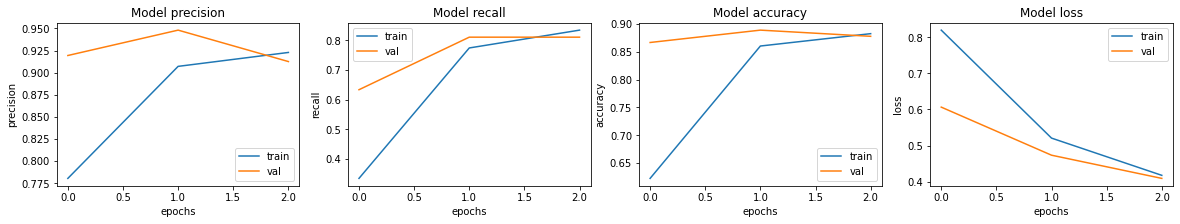

In [32]:
# Visualize model's performance
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Part 2: Developing the FViD with the selected pretrained graph

# Top Pretrained_Models on ship dataset
#1. ResNet101V2
#2. DenseNet169

#Try these attenton blocks on VID

In [33]:
# load the pre-trained model with global average pooling as the last layer and freeze the model weights
base_model = tf.keras.applications.ResNet101V2(include_top=False,input_shape=(224,224,3))
base_model.trainable = False
num_filters=64

#Vanila experiment
#Please add "pooling='avg' in the base_model"
clf_model = tf.keras.models.Sequential()
clf_model.add(base_model)
clf_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

numb=32
#Model_name = Vision Decoder
x = Conv2D(numb, 3, activation="relu", padding="same")(base_model.layers[-1].output)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(numb, 3, activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(numb, 3, activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(numb, 3, activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)


# Decoder
x = Conv2DTranspose(numb, 3, strides=2, activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2DTranspose(numb, 3, strides=2, activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2DTranspose(numb, 3, strides=2, activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2DTranspose(numb, 3, strides=2, activation="relu", padding="same")(x)


x = Flatten()(x)
    
output = Dense(num_classes,activation="softmax",name="fc"+str(num_classes))(x) 

clf_model =Model(inputs=base_model.inputs,outputs=output)


clf_model.compile(loss='categorical_crossentropy',metrics=['accuracy'])
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5)


In [34]:
clf_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_36[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# Plot the model
#keras.utils.plot_model(model, show_shapes=True, rankdir="LR")
#pydot.find_graphviz()
#keras.utils.plot_model(clf_model, show_shapes=True, to_file='FViD.png',dpi=120)

In [35]:
history = clf_model.fit(train_images,train_labels, epochs=100, validation_data=(val_images, val_labels),
                           steps_per_epoch=len(train_images)//batch_size, callbacks =[checkpoint, early_stopping])#,performance_cbk])

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.9335 - accuracy: 0.3937
Epoch 1: val_accuracy improved from -inf to 0.52222, saving model to model_weights.h5
9/9 [==============================] - 117s 12s/step - loss: 0.9335 - accuracy: 0.3937 - val_loss: 0.8219 - val_accuracy: 0.5222
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.6827 - accuracy: 0.6571
Epoch 2: val_accuracy improved from 0.52222 to 0.65556, saving model to model_weights.h5
9/9 [==============================] - 108s 12s/step - loss: 0.6827 - accuracy: 0.6571 - val_loss: 0.5352 - val_accuracy: 0.6556
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.5101 - accuracy: 0.6825
Epoch 3: val_accuracy did not improve from 0.65556
9/9 [==============================] - 105s 12s/step - loss: 0.5101 - accuracy: 0.6825 - val_loss: 0.5446 - val_accuracy: 0.6556
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.4668 - accuracy: 0.7206
Epoch 4: val_ac

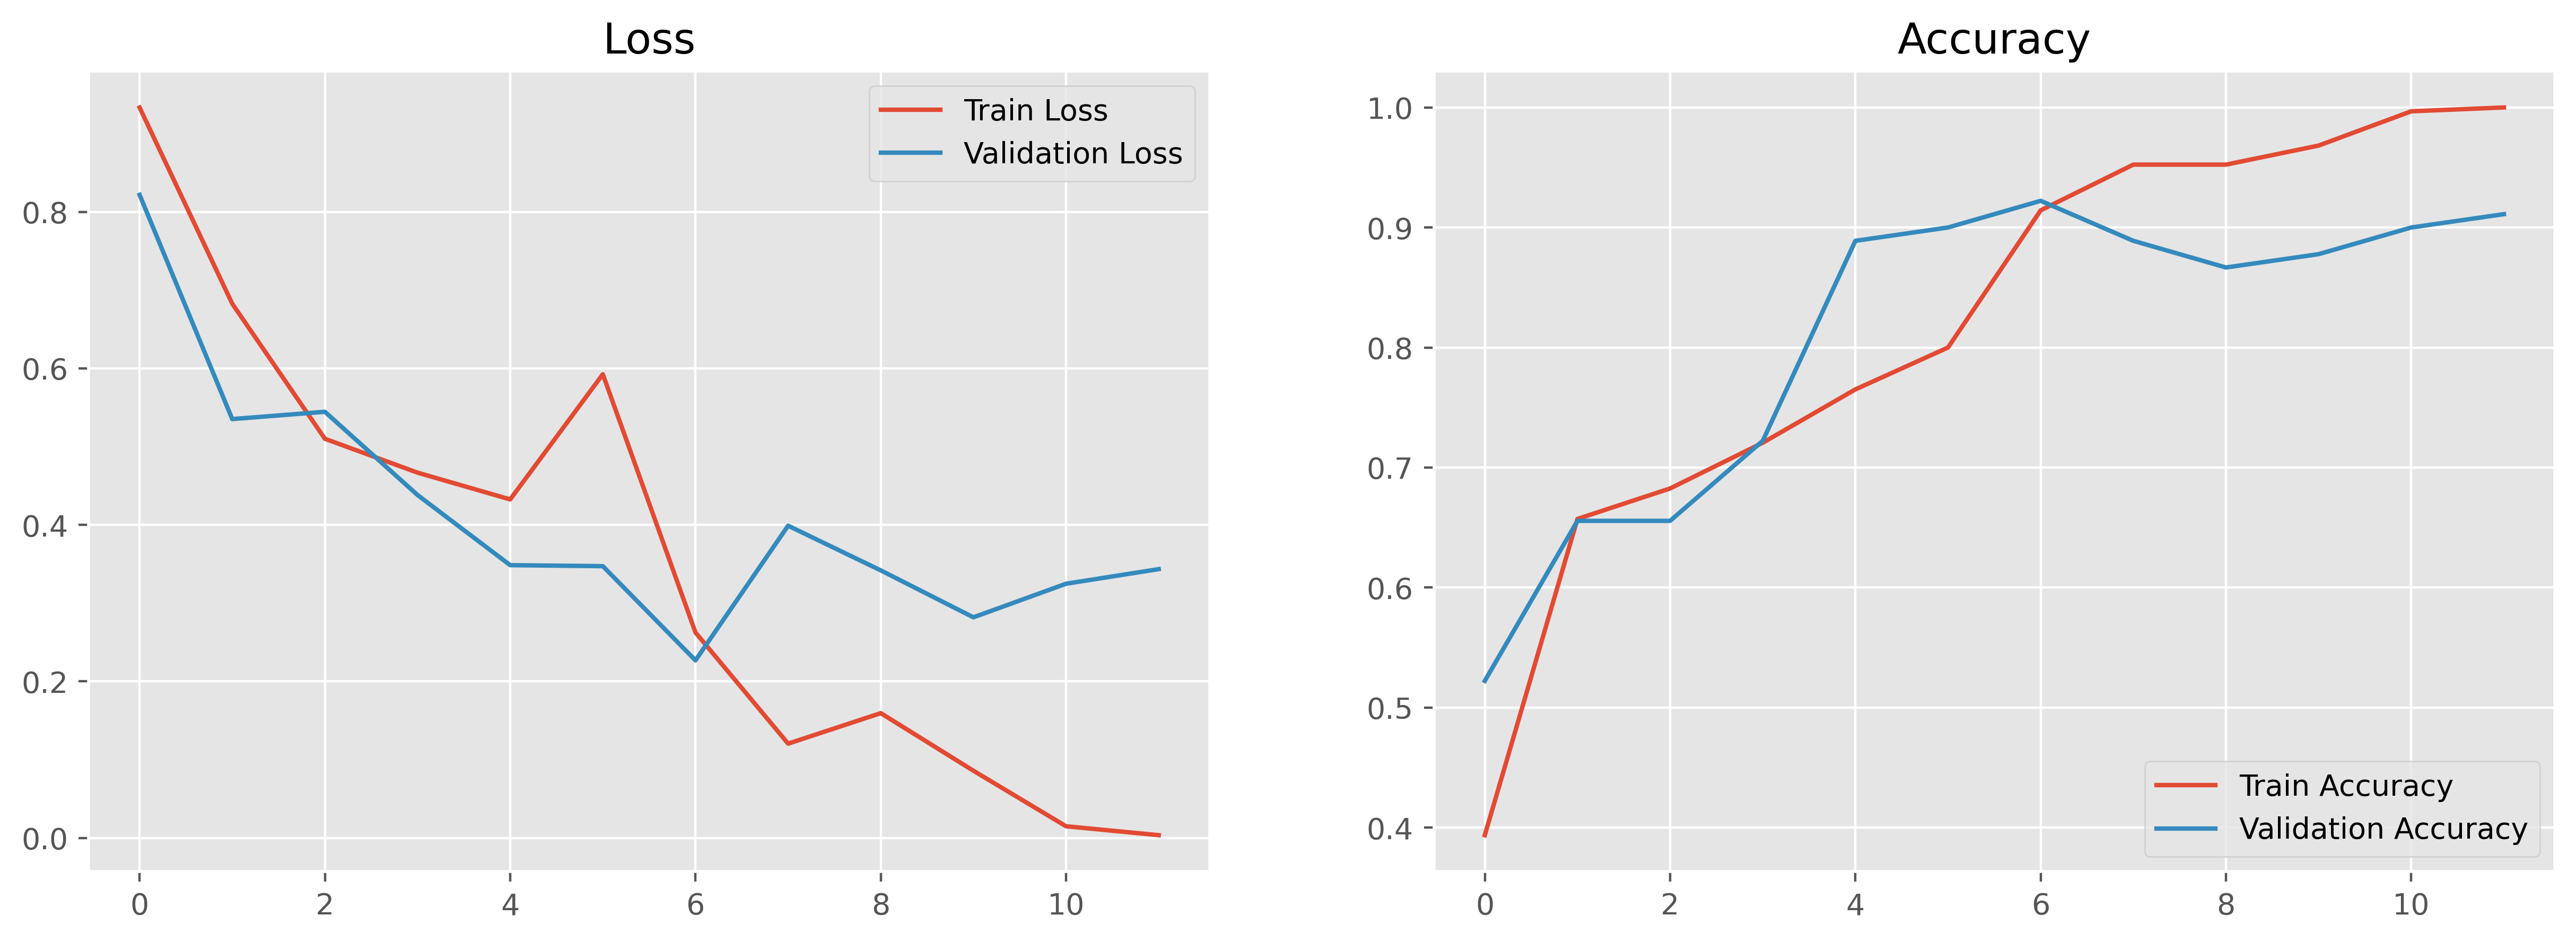

In [36]:
show_final_history(history)

In [37]:
#Load the best model and predict
val_pred = clf_model.predict(val_images)
val_pred = np.argmax(val_pred,axis=1)
val_pred.shape

(90,)

<Figure size 432x288 with 0 Axes>

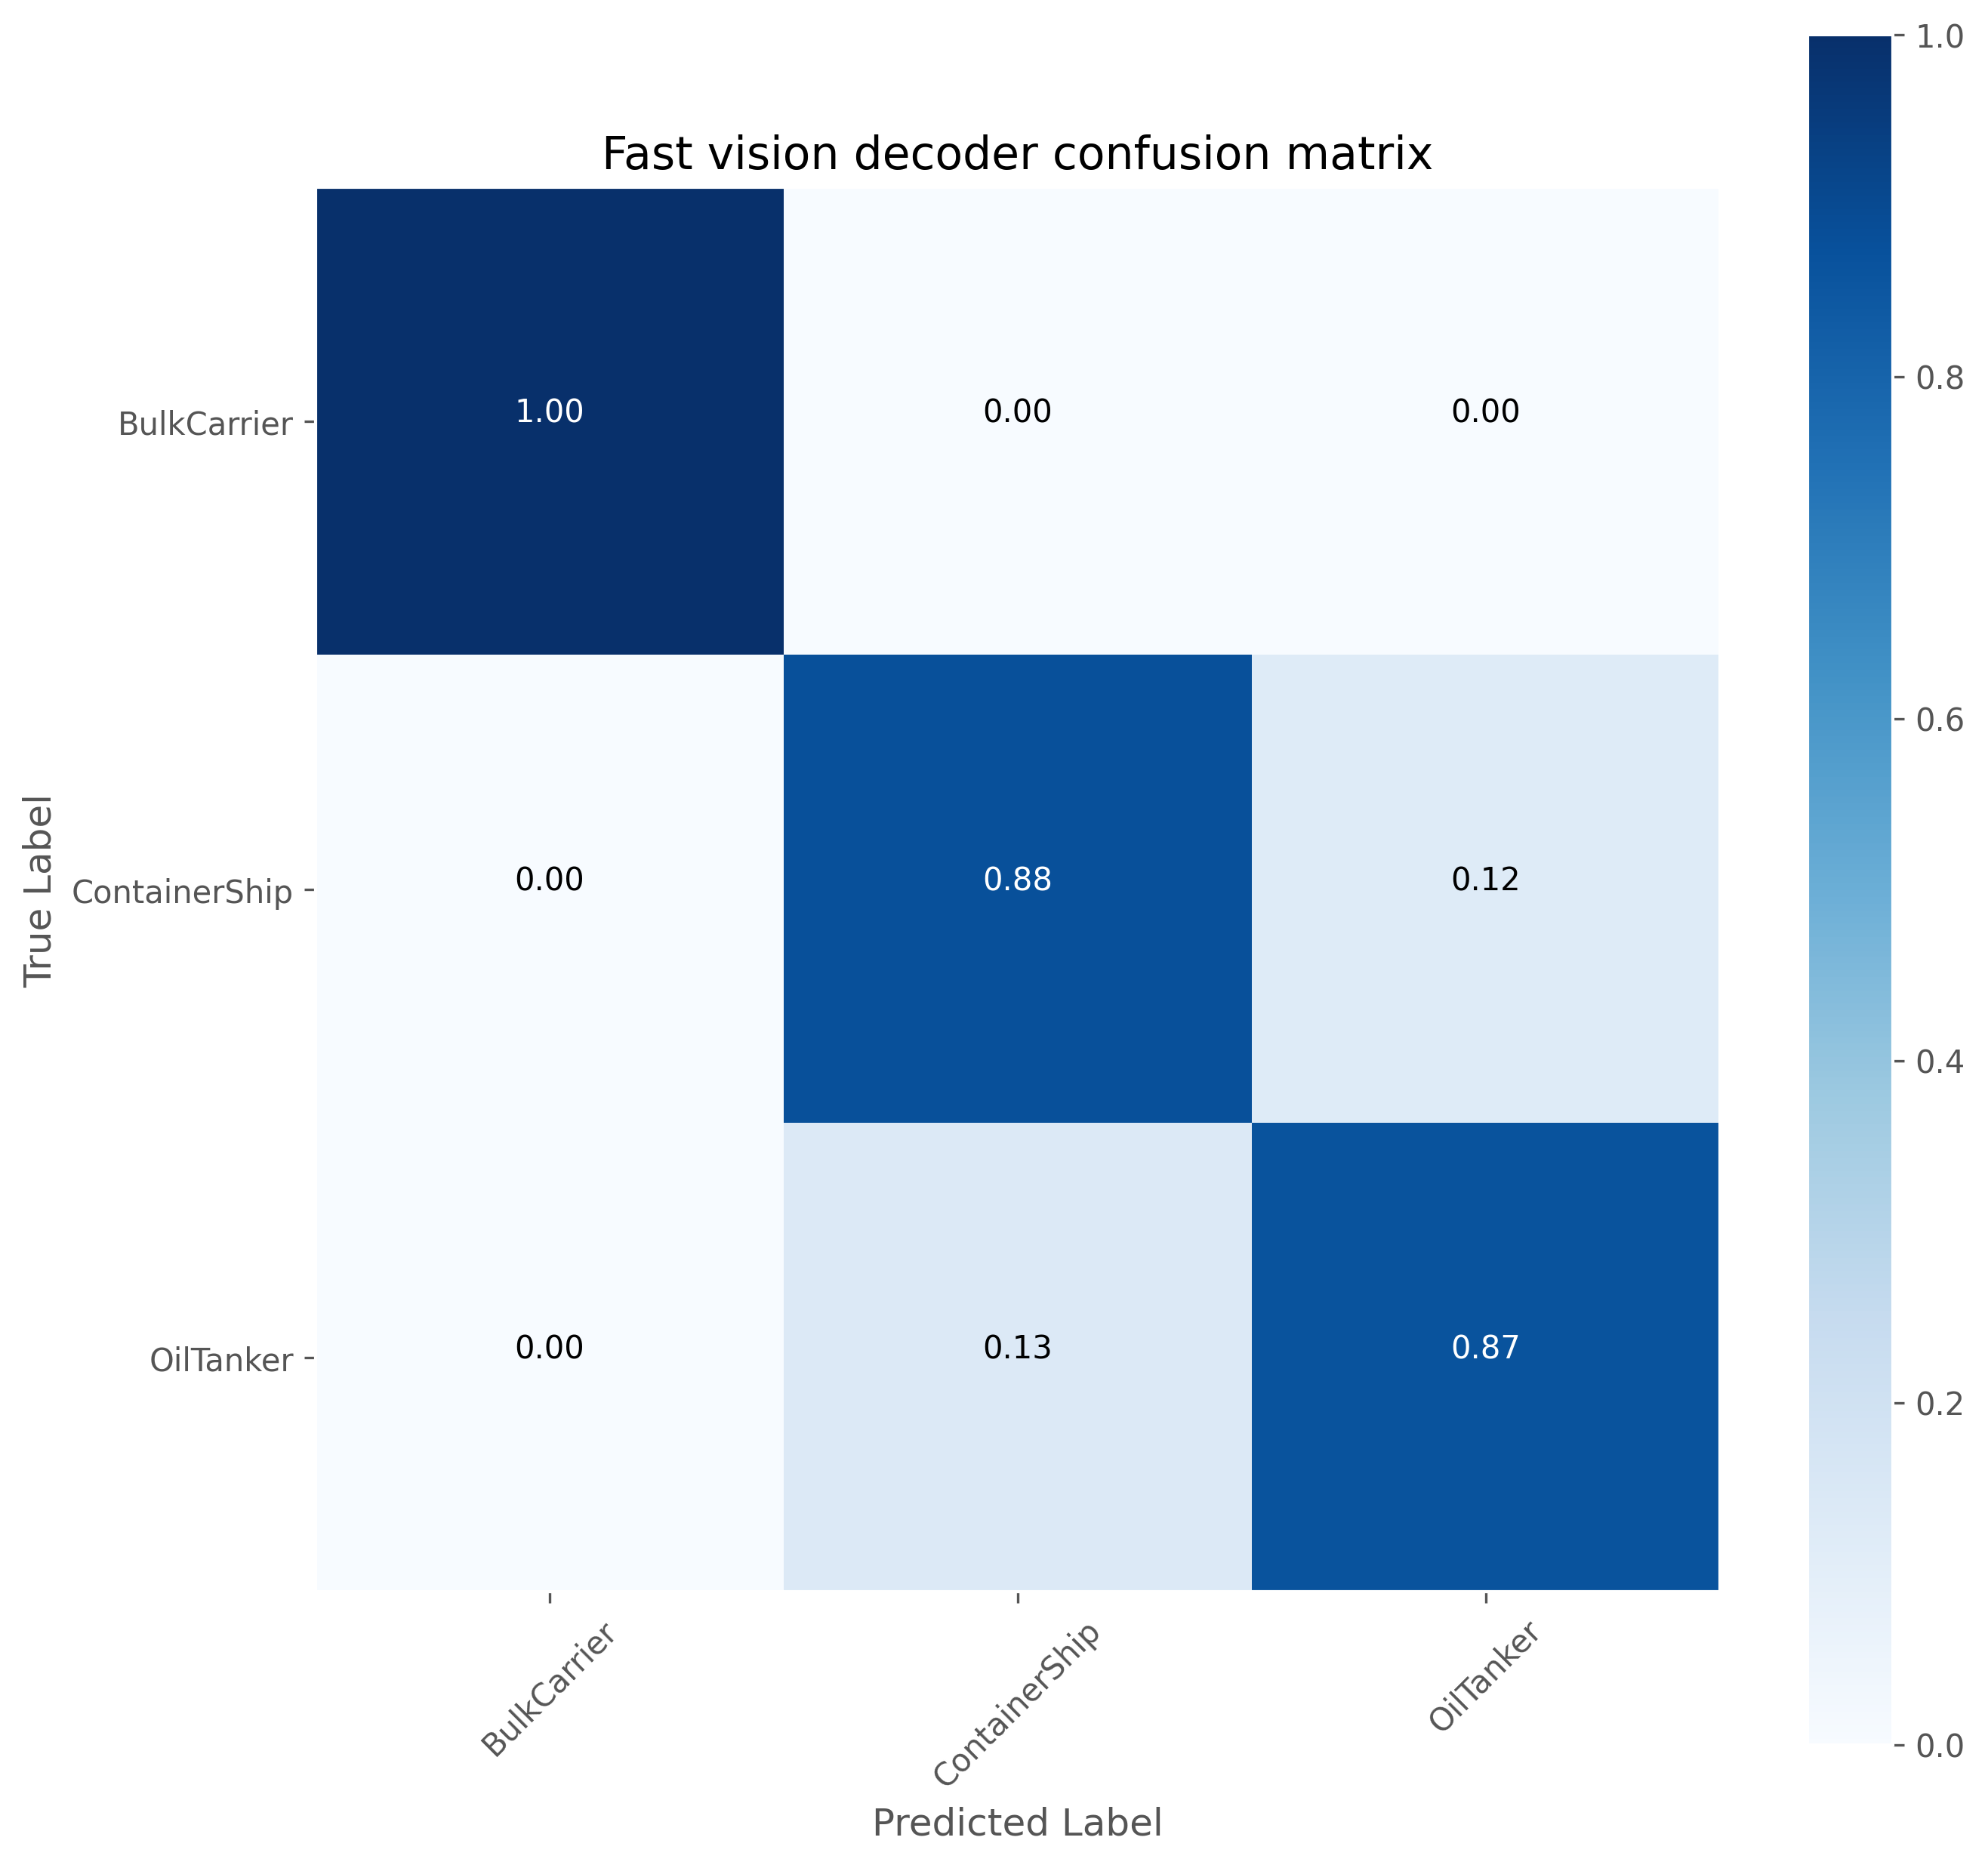

In [38]:
val_actual = np.argmax(val_labels,axis=1)

cnf_mat = confusion_matrix(val_actual, val_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix_final(cnf_mat,classes=class_names)
plt.grid(None)
plt.show();

In [39]:
test_pred = clf_model.predict(test_images)
test_pred = np.argmax(test_pred,axis=1)
test_pred.shape

(45,)

<Figure size 432x288 with 0 Axes>

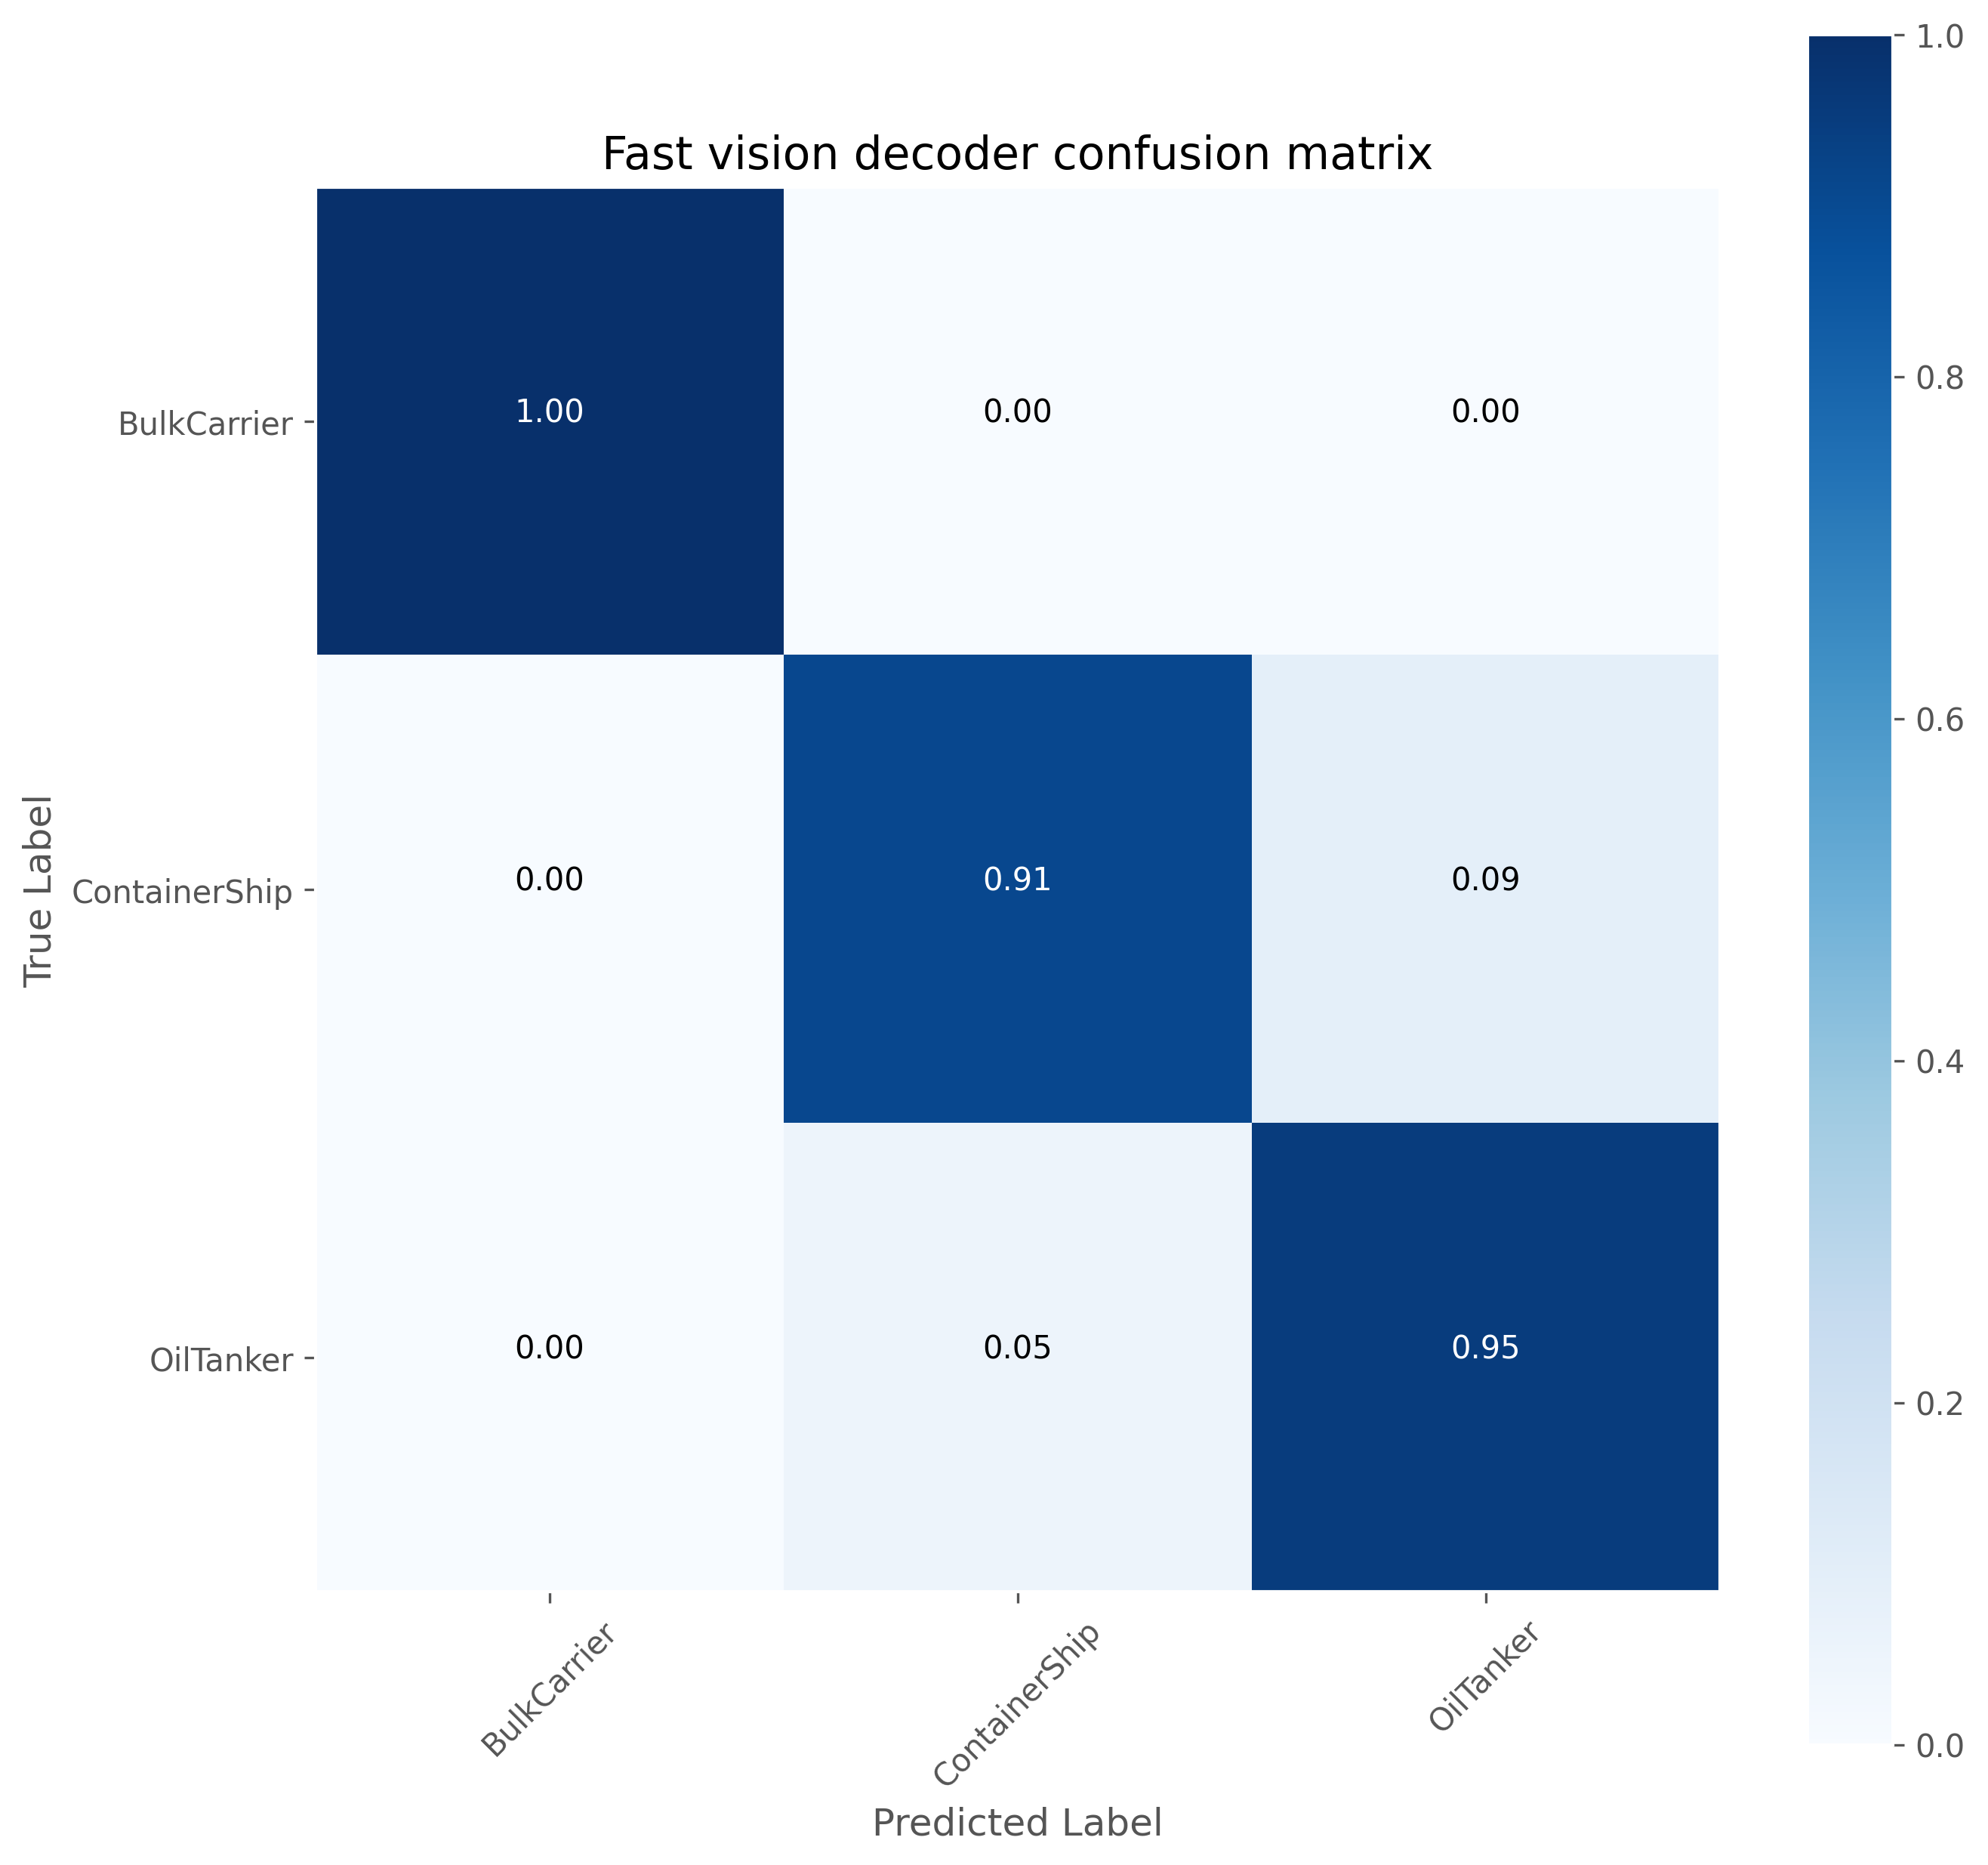

In [40]:
test_actual = np.argmax(test_labels,axis=1)

cnf_mat_test = confusion_matrix(test_actual, test_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix_final(cnf_mat_test,classes=class_names)
plt.grid(None)
plt.savefig("FVID_CM.tiff", format='tiff', bbox_inches='tight')
plt.show()

In [41]:
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score, average_precision_score,roc_auc_score, PrecisionRecallDisplay, jaccard_score, precision_score,recall_score,f1_score
print(classification_report(test_actual,test_pred, target_names = class_names))

               precision    recall  f1-score   support

  BulkCarrier       1.00      1.00      1.00        14
ContainerShip       0.91      0.91      0.91        11
    OilTanker       0.95      0.95      0.95        20

     accuracy                           0.96        45
    macro avg       0.95      0.95      0.95        45
 weighted avg       0.96      0.96      0.96        45



In [42]:
def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return
    y_pred = np.argmax(y_pred,axis=1)
    y_true = np.argmax(y_true,axis=1)

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df

In [43]:
report_with_auc = class_report(
    y_true=test_labels, 
    y_pred=clf_model.predict(test_images), 
    y_score=clf_model.predict(test_images))

print(report_with_auc)

             precision    recall  f1-score  support  pred       AUC
0             1.000000  1.000000  1.000000     14.0  14.0  1.000000
1             0.909091  0.909091  0.909091     11.0  11.0  0.997326
2             0.950000  0.950000  0.950000     20.0  20.0  0.998000
avg / total   0.955556  0.955556  0.955556     45.0  45.0  0.999012


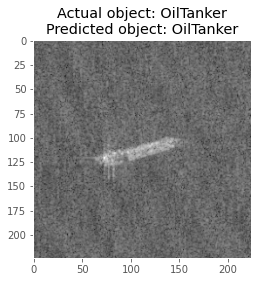

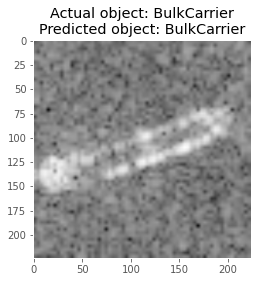

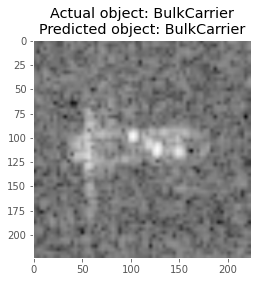

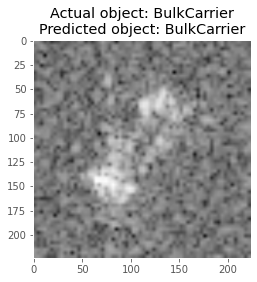

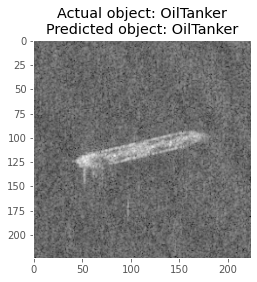

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


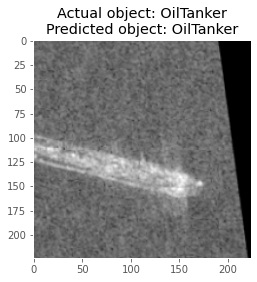

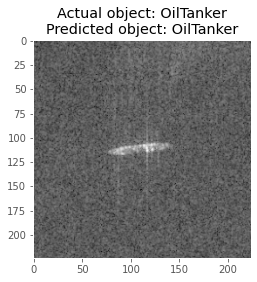

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


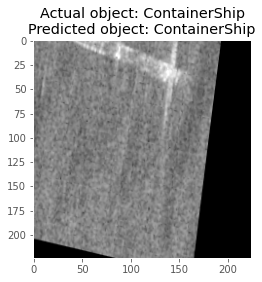

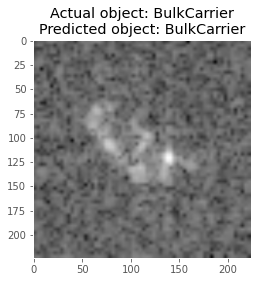

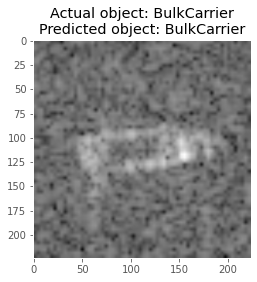

In [44]:
rnd_idx = random.sample(range(0,40),10)

class_labels = {i:class_name for (class_name,i) in class_name_labels.items()}
class_labels

# fig, ax = plt.subplots(2,5,figsize=(5,5))

for i,idx in enumerate(rnd_idx):
    
    plt.imshow(test_images[idx])
    plt.title("Actual object: {}\nPredicted object: {}".format(class_labels[test_actual[idx]],class_labels[test_pred[idx]]))
    plt.grid(None)
    #plt.savefig("final_loss_accuracy_plot.tiff", format='tiff', bbox_inches='tight')
    plt.show()
    pass